Cifar-10 Project

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
from tensorflow.keras import initializers
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Data uploading  

In [2]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()




tfds.datasets.imagenet_resized.Builder

Data Prerposessing

In [3]:
# Normalization
x_train=x_train/255.

x_test=x_test/255.

#One-hot encoding
y_train = tf.keras.utils.to_categorical(np.array(y_train))
y_test = tf.keras.utils.to_categorical(np.array(y_test))

In [4]:
#data augmentaion
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

Model 정의(CNN 기반)

In [7]:
def get_model():
    
    model=Sequential([
        Conv2D(filters=64,kernel_size=(1,1),padding='valid',input_shape=(256,320,320)),
        Conv2D(filters=64,kernel_size=(3,3),padding='valid',input_shape=(256,320,320)),
   
    ])


    lr_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 10000, 0.95 , staircase=False, name=None)

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),loss='categorical_crossentropy',metrics=['acc',tf.keras.metrics.Precision(name='precision')\
                          ,tf.keras.metrics.Recall(name='recall')],)

    return model

Callback 함수 정의

In [7]:
model_checkpoint_best_path=r'D:\GitHub_repo\Coursera\save_weights\cifar10_2/'
model_checkpoint_best=ModelCheckpoint(filepath=model_checkpoint_best_path,monitor='val_acc',save_best_only=True,save_weights_only=True,save_freq='epoch')
early_stopping=EarlyStopping(monitor='val_acc',patience=10,min_delta=1e-4)

In [8]:
log_dir=r'D:\GitHub_repo\Coursera\log_dir\log_dir_cifar10_3/'
tensorboard_callback=TensorBoard(log_dir=log_dir,histogram_freq=1)

Model 개요 및 시각화

In [8]:
model=get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 320, 64)      20544     
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 318, 64)      36928     
                                                                 
Total params: 57,472
Trainable params: 57,472
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(model,to_file='model.png',show_shapes=True)

In [ ]:
import visualkeras
visualkeras.layered_view(model, scale_xy=10, legend=True)

Model 학습

In [ ]:
model=get_model()
history=model.fit(datagen.flow(x_train,y_train,batch_size=64),epochs=200, validation_data=(x_test,y_test),verbose=2,callbacks=[model_checkpoint_best,early_stopping])

In [15]:
model=get_model()
model.load_weights(model_checkpoint_best_path)
test_loss,test_acc,test_presicion,test_recall=model.evaluate(x=x_test,y=y_test,verbose=1)

313/313 [==============================] - 5s 14ms/step - loss: 0.5744 - acc: 0.8915 - precision: 0.8959 - recall: 0.8894


Train 및 Validation metrics 시각화

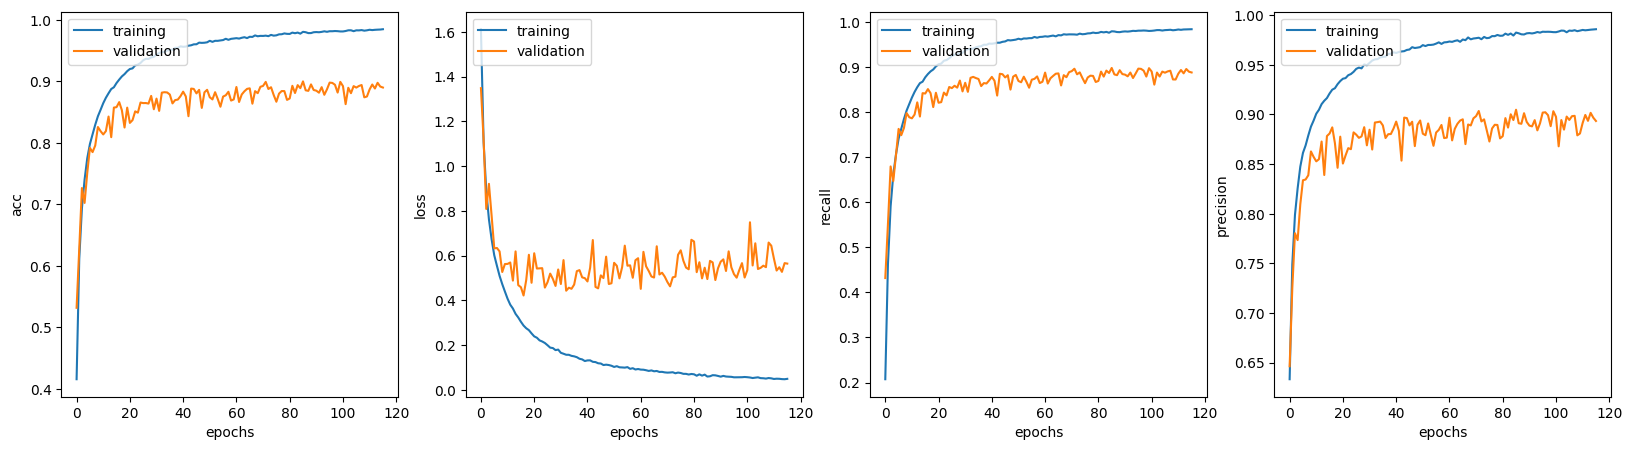

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.subplot(1,4,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.subplot(1,4,3)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.ylabel('recall')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.subplot(1,4,4)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.ylabel('precision')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')
plt.show()

Test dataset 검증

313/313 [==============================] - 2s 6ms/step
예측값: cat    실제값: cat
예측값: ship    실제값: ship
예측값: automobile    실제값: ship
예측값: airplane    실제값: airplane
예측값: frog    실제값: frog
예측값: frog    실제값: frog
예측값: automobile    실제값: automobile
예측값: frog    실제값: frog
예측값: cat    실제값: cat
예측값: automobile    실제값: automobile


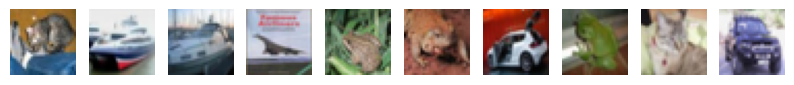

In [27]:
#Test dataset 검증 시각화
y_label=['airplane','automobile', 'bird' , 'cat' , 'deer',  'dog', 'frog' , 'horse','ship' ,'truck']

prediction=model.predict(x_test[...,:10])
ans=y_test
plt.figure(figsize=(10,10))

for i in range(10):
    print("예측값: {0}    실제값: {1}".format(y_label[np.argmax(prediction[i])],y_label[np.argmax(y_test[i])]))
    plt.subplot(1,10,i+1),plt.imshow(x_test[i]),plt.axis('off')  

plt.show()

외부 dataset을 통한 모델 검증(cat class)

In [38]:
import cv2
dir=os.listdir(r'D:\GitHub_repo\Coursera\Cifar_10_project\CAT_04/')
img_list=[]

for i in range(len(dir)):
    path=r'D:\GitHub_repo\Coursera\Cifar_10_project\CAT_04/'+dir[i]
    image=cv2.imread(path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    res=cv2.resize(image,(32,32))
    arr=np.array(res)
    img_list.append(arr)

img=np.array(img_list)

# 이미지 변환행렬 shape 확인
img.shape

(1396, 32, 32, 3)

In [29]:
# 정답레이블 만들기(Cat Class, 1396장의 고양이 사진으로 구성)
# 정답 레이블이 없는 경우 predict로 각각 이미지를 모두 연산해야함
# 정답 레이블을 직접 만들어서 evaluate로 확인 
# y_label 순서 -> ['airplane','automobile', 'bird' , 'cat' , 'deer',  'dog', 'frog' , 'horse','ship' ,'truck']

lst=[[0,0,0,1,0,0,0,0,0,0]]
for i in range(len(dir)-1):
    lst.append([0,0,0,1,0,0,0,0,0,0])

arr_label=np.array(lst)
# 정답레이블 shape 확인
arr_label.shape

(1396, 10)

44/44 [==============================] - 1s 18ms/step - loss: 101.7254 - acc: 0.1132 - precision: 0.1133 - recall: 0.1132


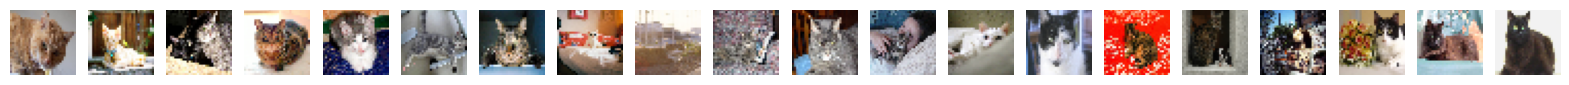

In [30]:
model=get_model()
model.load_weights(model_checkpoint_best_path)


test_loss,test_acc,test_precision,test_recall=model.evaluate(img,arr_label,verbose=1)
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(1,20,i+1),plt.imshow(img[i]),plt.axis('off')  

외부 dataset을 통한 모델 검증(frog class)
- download 받은 dataset은 이미 64x64로 되어있음.
- 따라서 resize과정을 통한 이미지 왜곡은 없음.

In [40]:
# 정답레이블 만들기(Frog Class,839장의 개구리 사진으로 구성)
import cv2

dir_frog=os.listdir(r'D:\GitHub_repo\Coursera\Cifar_10_project\frog/')
img_frog_list=[]

for i in range(len(dir_frog)):
    path_frog=r'D:\GitHub_repo\Coursera\Cifar_10_project\frog/'+dir_frog[i]
    image_frog=cv2.imread(path_frog,cv2.IMREAD_COLOR)
    image_frog = cv2.cvtColor(image_frog,cv2.COLOR_BGR2RGB)
    res_frog=cv2.resize(image_frog,(32,32))
    arr_frog=np.array(res_frog)
    img_frog_list.append(arr_frog)

img_frog=np.array(img_frog_list)

# 이미지 변환행렬 shape 확인
img_frog.shape

(839, 32, 32, 3)

In [32]:
lst_frog=[[0,0,0,0,0,0,1,0,0,0]]
for i in range(len(dir_frog)-1):
    lst_frog.append([0,0,0,0,0,0,1,0,0,0])

arr_label_frog=np.array(lst_frog)
# 정답레이블 shape 확인
arr_label_frog.shape

(839, 10)

27/27 [==============================] - 1s 16ms/step - loss: 118.0770 - acc: 0.0143 - precision: 0.0143 - recall: 0.0143


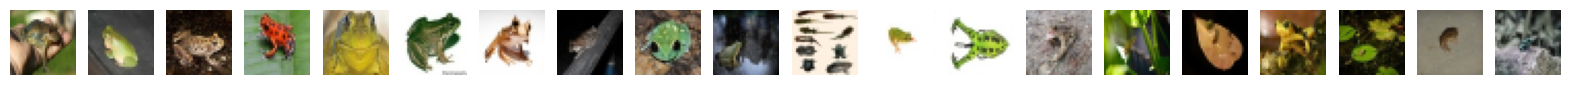

In [43]:
model=get_model()
model.load_weights(model_checkpoint_best_path)


test_loss,test_acc,test_precision,test_recall=model.evaluate(img_frog,arr_label_frog,verbose=1)
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(1,20,i+1),plt.imshow(img_frog[i]),plt.axis('off') 

낮은 acc결과에 대한 원인 분석
- 가로 혹은 세로가 긴 사진의 비율을 고려하지 않고 일괄적으로 32x32로 resize함, 이로 인해 외부 사진에 왜곡이 생겨 분류가 제대로 되지 않음
- frog 클래스는 이미지의 왜곡이 없었음에도 굉장히 낮은 정확도를 보임, 이에 대한 원인은 학습시 해당 클래스에 대한 과적합으로 밖에 설명이 안됨

추후 개선방향
- 내가 분류하고자 하는 대상을 중심으로 이미지를 crop하여,32x32로 resize.
- 해당 데이터셋으로 다시 test